# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from nltk.tokenize import word_tokenize
import string
import os
import re
from collections import Counter
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import community  #python-louvain package
import powerlaw
from wordcloud import WordCloud
from nltk import FreqDist
from urllib.parse import quote_plus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * Show the regular expressions you have built and explain in details how they work.

To extract the Wiki links from the rapper pages loop over the wiki page of each rapper. Here the page of the current rapper is denoted ``` text ``` . In this we know to look for the pattern ```[[link]]``` or ```[[link | alias]]```. Therefore we have used a regular expression in the following way: 

```python
pattern = r"\[\[(.+?)\]\]"
links = re.findall(pattern, text)
```

Here the ``findall`` function ensures that all instances of matches are found. The pattern is defined as follows:

* ``\[\[`` : The pattern starts with two square brackets
* ```(.+?)``` : The pattern group (denoted with ``()``) continues with any character (```.```) between one and unlimited times (```+```). Finally the question mark ensures that the pattern is "lazy".
* ```\]\]``` : The pattern ends with two square brackets

Finally we add the following line to remove the alias from the links:
    
```python
links = [link.split('|')[0] for link in links]
```
Hereby a list of links is created for this rapper and we can extract those that are links to other rappers.

# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

### Extract network

In [2]:
# load the graph
G = nx.read_gexf('data/rapper_network.gexf')

# extract largest weakly connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
g = G.subgraph(largest_cc)

# define undirected graph (used in exercise 3)
H = g.to_undirected()

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.



In [3]:
# print the number of nodes and edges
print("Number of nodes: ", g.number_of_nodes())
print("Number of links: ", g.number_of_edges())

Number of nodes:  728
Number of links:  5824


In [118]:
# find most connected rapper
in_degree_dict = dict(g.in_degree(g.nodes()))
out_degree_dict = dict(g.out_degree(g.nodes()))
degree_dict = dict(g.degree(g.nodes()))

# sort the dictionary by degree
print("Highest in-degree:", max(in_degree_dict, key=in_degree_dict.get), ",", in_degree_dict[max(in_degree_dict, key=in_degree_dict.get)])
print("Highest out-degree:", max(out_degree_dict, key=out_degree_dict.get), ",", out_degree_dict[max(out_degree_dict, key=out_degree_dict.get)])

Highest in-degree: Snoop Dogg , 125
Highest out-degree: Drag-On , 52


The rapper with the highest in-degree is Snoop Dogg. Hence he is the most referenced by other rappers wikitexts. Since Snoop Dogg is a well known rapper with a large discography we can expect a large number of references to him. Also based on his Wikipedia text he appears very influential in rap. Hence a large number of connections is expected. On the other hand Drag-On has the most references to other rappers. He appears to be less influential, hence it is expected to have a large number of references to other rappers and thereby larger out-degree.

### Top connected east and west coast rappers

First we extract the in-and out-degrees from both east and west.

In [119]:
# find most connected rappers from east and west coast
central_nodes_in = sorted(g.in_degree, key=lambda x: x[1], reverse=True)
central_nodes_out = sorted(g.out_degree, key=lambda x: x[1], reverse=True)

central_nodes_in_east = []
central_nodes_in_west = []
central_nodes_out_east = []
central_nodes_out_west = []

for node in central_nodes_in:
    if g.nodes[node[0]]['Coast'] == 'East':
        central_nodes_in_east.append(node)
    else:
        central_nodes_in_west.append(node)

for node in central_nodes_out:
    if g.nodes[node[0]]['Coast'] == 'East':
        central_nodes_out_east.append(node)
    else:
        central_nodes_out_west.append(node)


In [120]:
# Most connected east coast rappers
print("Top 5 highest in-degree east coast rappers:")
for i in range(5):
    print(str(i+1)+ ")"+str(central_nodes_in_east[i])[1:-1])

print("\n")
print("Top 5 highest out-degree east coast rappers:")
for i in range(5):
    print(str(i+1)+ ")"+str(central_nodes_out_east[i])[1:-1])


Top 5 highest in-degree east coast rappers:
1)'Jay-Z', 115
2)'Nas', 98
3)'50 Cent', 92
4)'Busta Rhymes', 83
5)'The Notorious B.I.G.', 63


Top 5 highest out-degree east coast rappers:
1)'Drag-On', 52
2)'Black Thought', 42
3)'Jahlil Beats', 35
4)'MC Lyte', 35
5)'Uncle Murda', 34


In [121]:
# Most connected west coast rappers
print("Top 5 highest in-degree west coast rappers:")
for i in range(5):
    print(str(i+1)+ ")"+str(central_nodes_in_west[i])[1:-1])

print("\n")
print("Top 5 highest out-degree west coast rappers:")

for i in range(5):
    print(str(i+1)+ ")"+str(central_nodes_out_west[i])[1:-1])

Top 5 highest in-degree west coast rappers:
1)'Snoop Dogg', 125
2)'Dr. Dre', 81
3)'Kendrick Lamar', 75
4)'Tupac Shakur', 70
5)'E-40', 63


Top 5 highest out-degree west coast rappers:
1)'DJ Dahi', 38
2)'Kendrick Lamar', 37
3)'Dr. Dre', 36
4)'The Game (rapper)', 36
5)'Kurupt', 35


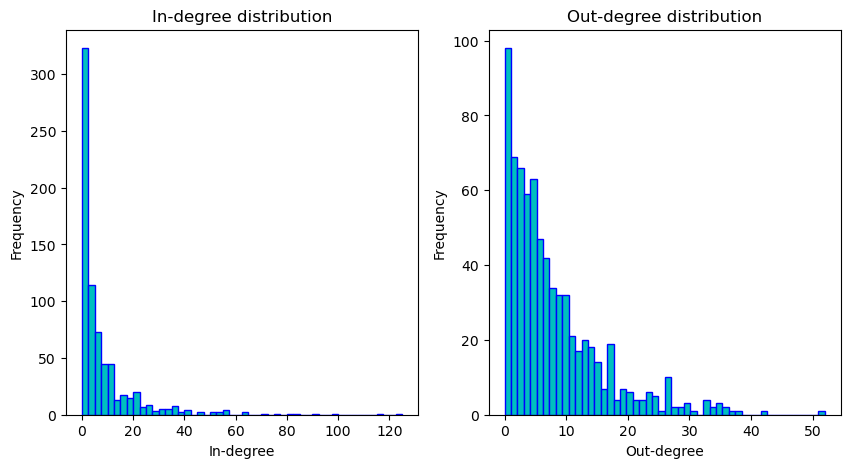

In [122]:
# plot distribution of in- and out-degrees

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(in_degree_dict.values(), bins = 50, color='c',edgecolor = 'blue')
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(out_degree_dict.values(), bins = 50, color='c', edgecolor='blue')
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")
plt.show()

In the figure we can observe that the in-degree distribution is different from the out-degree distribution. It is noticiable that the in-degree reaches much higher values than the out-degree. Furthermore the in-degree distribution is more skewed than the out-degree distribution with a higher frequence for low in-degree values. Logically the in-degree distribution is more skewed than the out-degree distribution since less rappers are referenced by many other rappers than the other way around. Most rappers in the network are less known and therefore referenced by less other rappers. On the other hand the most famous rappers are referenced by many other rappers. Also the less known rappers most likely have shorter carees and discografies hence less references to other rappers.

### Exponent of distributions 

In [123]:
a_in = powerlaw.Fit(list(in_degree_dict.values())).alpha
a_out = powerlaw.Fit(list(out_degree_dict.values())).alpha

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [126]:
print("alpha- in degree:", f'{a_in:.3f}')
print("alpha- out degree:", f'{a_out:.3f}')

alpha- in degree: 2.748
alpha- out degree: 12.016


Using the powerlaw package we find that the exponent of the in-degree distribution is 2.7 and the exponent of the out-degree distribution is 12.0. A smaller alpha means a heavier tailed distribution, which corresponds to the larger value range of in-degrees. In the opposite the out-degree has a much shorter tail since the value range is much smaller hence a larger exponent. In the histrograms in the previous exercise we can furthermore observe that the out-degree distribution quickly tails out compared to the in-degree distribution. Hence both networks are networks with powerlaw distributions. 

### Comparison to a random network

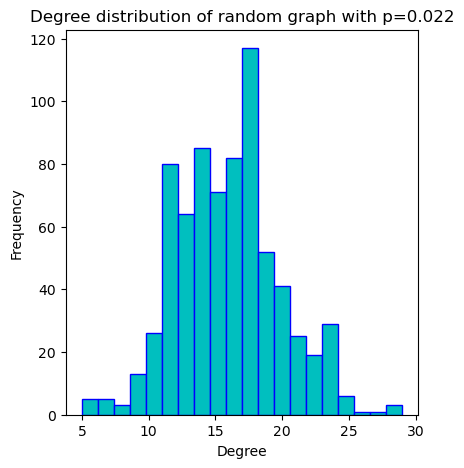

In [127]:
# find probability of edge creation
p = (g.number_of_edges()*2)/(g.number_of_nodes()*(g.number_of_nodes()-1))
random_graph = nx.erdos_renyi_graph(g.number_of_nodes(), p)

# plot degree distribution of in and out degree
degrees = [random_graph.degree(n) for n in random_graph.nodes()]

# create subplots
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(degrees, bins=20, color='c', edgecolor='blue')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution of random graph with p='+ str(round(p, 3)))
plt.show()


The random network follows a poisson distribution. Here we do not see the same tendency to a tailed distribution. Hence in the random network we do not observe hubs (nodes with a much higher degree than the rest of the network) in the same way as observed for the rapper network. Instead the highest frequency can be observed for the middle values of the distribution. Furthermore the random network has a much smaller value range than the rapper network. 

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

The following code creates a visualization of the directed network with the notes being blue for west coast rappers and red for east coast rappers. Additionally the size of the nodes is scaled depending on the degree of the node. This is done by defining the node size as the degree multiplied by 10. In order to clearly illustrate the relationship between the nodes, each edge has been given a specific color. The edge is red if an east coast node leads to another east coast node. The edge is blue if a west code node leads to a west code node. The edge is green if and an east coast node leads to a west cost node, or the other way around. Furthermore the kamada kawai layout is used to position the nodes.

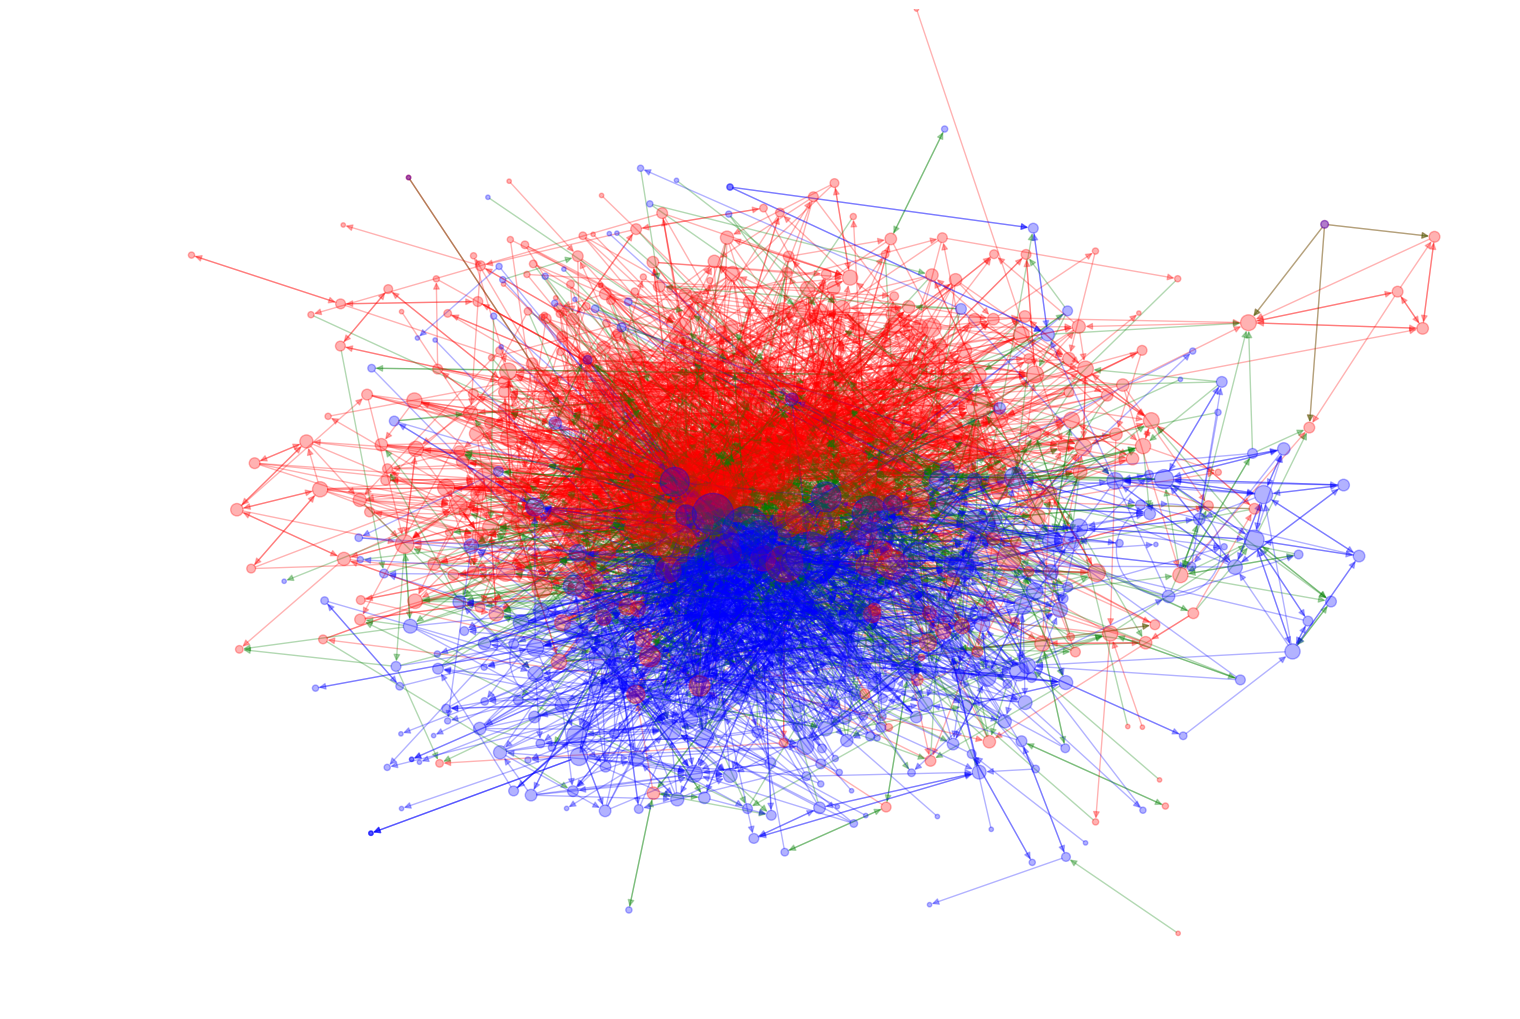

In [128]:
# Create a set of nodes from the east coast and west coast based on the CSV files for east coast rappers and west coast rappers
df_rappers = pd.read_csv("data/Rappers.csv")

east_coast_nodes = df_rappers[df_rappers["Coast"] == "East"]["WikipediaPageName"].tolist()
west_coast_nodes = df_rappers[df_rappers["Coast"] == "West"]["WikipediaPageName"].tolist()

# Set the 'coast' attribute for each node
for node in g.nodes():
    if node in east_coast_nodes:
        g.nodes[node]["Coast"] = "EastCoast"
    elif node in west_coast_nodes:
        g.nodes[node]["Coast"] = "WestCoast"
    
# Create a list of colors for node visualization based on the 'coast' attribute
node_colors = ["red" if g.nodes[node]["Coast"] == "EastCoast" else "blue" for node in g.nodes()]

#Creates a list of node sizes depending on the node degree
node_sizes = [10 * g.degree[node] for node in g.nodes()]

#Sets colors based on the role of the edge
edge_colors = []
for u, v in g.edges():
    if g.nodes[u]["Coast"] == "EastCoast" and g.nodes[v]["Coast"] == "EastCoast":
        edge_colors.append("Red")
    elif g.nodes[u]["Coast"] == "WestCoast" and g.nodes[v]["Coast"] == "WestCoast":
        edge_colors.append("Blue")
    else:
        edge_colors.append("Green")

#Plot figure
plt.figure(figsize=(15, 10))

# Choose a layout algorithm
pos = nx.kamada_kawai_layout(g)

#Draw the graph
nx.draw(g, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color=edge_colors, alpha=0.3)

#Set axis/zoom in or out
x_min, x_max = -1, 1
y_min, y_max = -1, 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

#show figure
plt.show()

In the graph we can observe a partition between east and west coast rappers. This is illustrated by the red and blue nodes. Furthermore we can observe that smaller node-size, is often connected to larger nodes with the same color. This observation might be an indication of preferential attachment and hereby creation of hubs. We can also see from the network that connections across coast are less frequent than connections within coast. This is illustrated by the green edges being less frequent than the red and blue edges but stil visibly present.

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

### Create east and west corpus and clean text
In the following section we create a corpus consisting of an the wikitext of each east coast and west coast text seperatly. The text is cleaned by tokenizing, setting all words to lowercase, remove punctuation and remove stopwords.

Load the dataframe using Pandas

In [129]:
df_rappers = pd.read_csv("data/Rappers.csv")

Define API parameters

In [130]:
# Define API parameters
api_url = 'https://en.wikipedia.org/w/api.php'
api_params = {
    'action': 'query',
    'prop': 'extracts',
    'exlimit': '1',
    'explaintext': '1',
    'format': 'json'
}

Create the corpus that all of the files will be downloaded to

In [131]:
corpus_dir = 'rapper_corpus'
os.makedirs(corpus_dir, exist_ok=True)

Create a seperate list of east coast rappers and west coast rappers using Pandas

In [132]:
east_coast_rappers = df_rappers[df_rappers['Coast'] == 'East']['WikipediaPageName'].tolist()
west_coast_rappers = df_rappers[df_rappers['Coast'] == 'West']['WikipediaPageName'].tolist()

Create a function that downloads the wikipedia pages to the corpus in txt files

In [133]:
def create_corpus(rapper_list, corpus_name):
    corpus = ""
    for rapper_name in rapper_list:
        api_params['titles'] = rapper_name
        encoded_rapper_name = quote_plus(rapper_name)

        response = requests.get(api_url, params=api_params)
        data = response.json()

        # Extract text from the JSON response
        page_data = data['query']['pages']
        page_id = list(page_data.keys())[0]
        rapper_text = page_data[page_id]['extract']

        # Append the text to the corpus
        corpus += rapper_text

    # Create a text file for the corpus
    with open(os.path.join(corpus_dir, f'{corpus_name}_corpus.txt'), 'w', encoding='utf-8') as file:
        file.write(corpus)

Create a seperate corpus for each of the coasts

In [ ]:
create_corpus(east_coast_rappers, 'east')
create_corpus(west_coast_rappers, 'west')

The next code cleans-up the text by tokenizing the text, removing punktuations, making every letter lower case and removing stop words

In [134]:
def clean_text(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Convert to lowercase
        token = token.lower()
        
        # Remove punctuation
        if token not in string.punctuation:
            # Remove stopwords
            if token not in stopwords.words('english'):
                clean_tokens.append(token)

    return clean_tokens

### Create TF-TR list and plot wordcloud

The following code is a function that creates a TF list using the NLTK frequency distribution function to find the frequency of all the words in the cleaned up texts.

In [135]:
# Create a Term Frequency (TF) list
def create_tf_list(corpus_name):
    with open(os.path.join(corpus_dir, f'{corpus_name}_corpus.txt'), 'r', encoding='utf-8') as file:
        corpus_text = file.read()
        clean_tokens = clean_text(corpus_text)

        # Calculate the TF list
        tf_list = nltk.FreqDist(clean_tokens)

        return tf_list

This code creates the TF-lists for the east coast rappers and the west coast rappers

In [136]:
east_coast_tf_list = create_tf_list('east')
west_coast_tf_list = create_tf_list('west')

The next thing to be done is to create a function that calculates the ratio of each word in both of the lists, using the method explained for the TF-TR excersise in the week 7 notebook. In this function the ratio lists also get sorted in descending order.

In [ ]:
def calculate_ratio(tf_list1, tf_list2, c):
    ratios = {}
    for word, freq1 in tf_list1.items():
        freq2 = tf_list2[word] 
        if word in tf_list2:
            ratio = freq1 / (freq2 + c)
            ratios[word] = ratio
        else:
            ratios[word] = 0

    sorted_ratios = sorted(ratios.items(), key=lambda item: item[1], reverse=True)
    return sorted_ratios        

The next piece of code generates the TF-TR ratio for all of the tokens in the east coast text and in the west coast text. The constant c is set to be 1. The lists used in the calculate_ratio function must be switched when creating the west coast ratio list, in order to get the right ratio for each coast.

In [ ]:
c = 1 
sorted_east_coast_ratios = calculate_ratio(east_coast_tf_list, west_coast_tf_list, c)
sorted_west_coast_ratios = calculate_ratio(west_coast_tf_list, east_coast_tf_list, c)

Since the TF-TR lists for both east coast rappers and west coast rappers have been generated and sorted, the word cloud can easily be constructed. Here we use the Wordcloud package to create the wordclouds. The wordclouds are created using the TF-TR lists and are plotted using the matplotlib package.

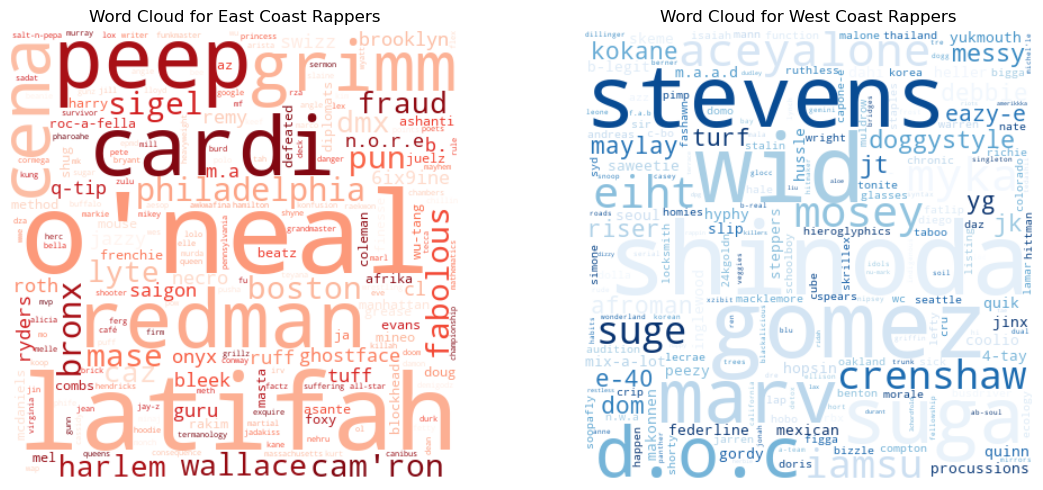

In [86]:
# Create word clouds and display them side by side
plt.figure(figsize=(12, 5))

# Word cloud for East Coast
plt.subplot(1, 2, 1)
wordcloud_east = WordCloud(width=400, height=400, background_color='White', colormap="Reds").generate_from_frequencies(dict(sorted_east_coast_ratios))
plt.imshow(wordcloud_east, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for East Coast Rappers")

# Word cloud for West Coast
plt.subplot(1, 2, 2)
wordcloud_west = WordCloud(width=400, height=400, background_color='White', colormap="Blues").generate_from_frequencies(dict(sorted_west_coast_ratios))
plt.imshow(wordcloud_west, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for West Coast Rappers")

plt.tight_layout()
plt.show()

The next part shows the five words for each coast, with the highest ratio.

In [90]:
print("Top 5 words for East Coast rappers:")
for i in range(5):
    print(str(i+1)+ ")"+str(sorted_east_coast_ratios[i])[1:-1])

print("\n")
print("Top 5 words for West Coast rappers:")
for i in range(5):
    print(str(i+1)+ ")"+str(sorted_west_coast_ratios[i])[1:-1])

Top 5 words for East Coast rappers:
1)"o'neal", 76.0
2)'latifah', 69.0
3)'peep', 40.25
4)'cardi', 39.25
5)'redman', 37.0


Top 5 words for West Coast rappers:
1)'shinoda', 47.0
2)'wid', 41.0
3)'gomez', 40.0
4)'stevens', 33.0
5)'suga', 27.0


In the wordclouds above we can observe words highly related to the coast they represent. Words such as Philidelphia and Boston are highly geographically related to the east coast. Similarily words such as Crenshaw is geographically connected to the west coast. Furthermore in both wordclouds we can observe words such as Cardi and Afroman respectivly which are rappers from each of the respective coasts. The top 5 highest ratios words are similarily words that are highly related to the coast they represent. Hence it makes sence that these words have the highest ratios.

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 


### Modularity explained

Communities refers groups of nodes that are densely connected to each other, but not very connected to nodes outside of the community. In order to determine the strength of the communities modularity is measured. A high modularity indicates that the network has a strong community structure between nodes within the community. A low modularity indicates a weaker community structure, and suggests that the network is closer to being a random network, with weak or not well-defined communities. Hence modularity describes the difference between edges within communities and the expected number of edges if all the edges were placed at random.

The formula is given as follows:

$$
Q = 
\frac {1}{2m}
\sum _{vw} \left[A_{vw} - \frac {k_v k_w}{2m}\right]
\frac {s_v s_w + 1}{2}
$$

The variables are given as:
* $m$ is the total number of edges in the network and $v$ and $w$ is two distinct nodes. 
* $A_{vw}$ is the adjacency matrix
* $k_v$ and $k_w$ are the nodes' degrees. 
* $s_v$ and $s_w$ is either 1 or -1 depending on what community the node belongs to.

The first fraction is simply a normalisation factor for the modality to stay between 0 and 1.
In the paranthesis the first part is the actual number of edges between $v$ and $w$ from which we subtract the expected number of edges between $v$ and $w$. The last fraction can either be 0 or 1. If the two nodes are from the same community its 1 and if they are not it will be 0. In that way only the edges between nodes within a community is included in Q.

### Communities in the rapper network

> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?

We use the undirected network created in assignment 1. With this network we use the Python-Louvain algortihm to create a partition.

The Louvain algorithm is based on the idea of optimizing modularity.
In the method of community detection, it first finds small communuties by optimizing modularity locally on all nodes.
Then each small community is grouped into one node and the first step is repeated.

In [31]:
# Detect communities using the Python-Louvain algorithm
partition = community.best_partition(H)

> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.

We calculate the number of communities:

In [32]:
# Find the number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 9


Next we find the modularity uin the function from community package:

In [33]:
modularity_value = community.modularity(partition, H)
print(f"Modularity: {modularity_value}")

Modularity: 0.4168921742679319


Then we draw the network with the nodes colored by community. We expect everything to appear a bit "random" and very packed together based on the modularity.

Community sizes: [139, 49, 151, 174, 37, 158, 2, 11, 7]


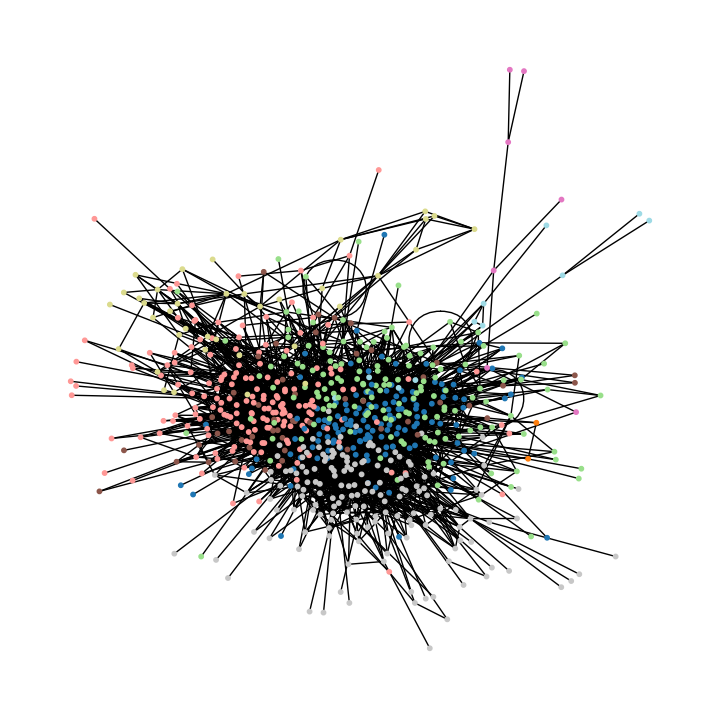

In [38]:
# Get the community ID for each node
community_ids = list(partition.values())

# print community sizes
community_sizes = list(Counter(community_ids).values())
print("Community sizes:", community_sizes)

# Define a colormap for visualizing communities
colormap = plt.cm.get_cmap("tab20", max(community_ids) + 1)

# Map community IDs to colors
node_colors = [colormap(community_id) for community_id in community_ids]

# Draw the network graph with community-based node colors
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(H, seed=42)
nx.draw(H, pos, node_color=node_colors, with_labels=False, node_size=10)
plt.show()

We see that the graph is divided into 8 communities where 4 of them are significantly larger than the other 4. As we can see in the network above the communities are quited packed together, however we can still distringuish some of the communities individually.  The modularity is less than half of possible maximum value, which corresponds well with the figure above. Also the network appears somewhat random which would result in the lower modularity.

> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

We sort the rappers into two different dictionaries and calculate each communties modularity

In [27]:
# Divide the nodes into two communities based on the coast attribute
# Create a set of nodes from the east coast and west coast based on the CSV files for east coast rappers and west coast rappers
df_rappers = pd.read_csv("data/Rappers.csv")

# Getting the data
east_codes_nodes = df_rappers[df_rappers["Coast"]=="East"]["WikipediaPageName"].tolist()
west_codes_nodes = df_rappers[df_rappers["Coast"]=="West"]["WikipediaPageName"].tolist()

rappers_communities = {}
for node in H.nodes():
    if node in east_codes_nodes:
        rappers_communities[node] = 1
    else:
        rappers_communities[node] = 0

modularity_value1 = community.modularity(rappers_communities, H)
print(f"Modularity of east-west split: {modularity_value1: .3f}")

Modularity of east-west split:  0.249


Splitting the graph into east and west results in a modularity of 0.249 which is much lower than the best partition. Hence this partition results in a much weaker community structure than the best partition. This is expected since the best partition splits the graph into 8 communities and hence better capture the community structure of the network.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**



### Load sentiment wordlist

In [138]:
# load txt
labmt = pd.read_csv("data/LabMT.txt", sep='\t')

# load rappers
rappers = pd.read_csv("data/Rappers.csv", sep=',')
rappers_names = list(rappers['WikipediaPageName'])

### Define function for sentiment scores

In [164]:
def sentiment_score(text):
    text = word_tokenize(text)
    text = [word.lower() for word in text if word.isalpha()]

    total = 0
    sent = 0
    fdist = FreqDist(text)
    for word in fdist:
        if word in list(labmt['word']):
            sent += labmt['happiness_average'].loc[labmt['word'] == word].values[0] * fdist[word]
            total += fdist[word]

    sent /= total

    return sent

### Find sentiment for all rappers

In [165]:
def sentiment_rappers(rappers):
    rappers_happiness = {}
    for rapper in rappers:
        with open("data/rappers_text/"+rapper+'.txt') as f:
            try:
                rapper_text = f.readlines()[0]
            except:
                continue

        rappers_happiness[rapper] = sentiment_score(rapper_text)

    return rappers_happiness

rappers_happiness = sentiment_rappers(rappers_names)

### Plot histogram of sentiment scores

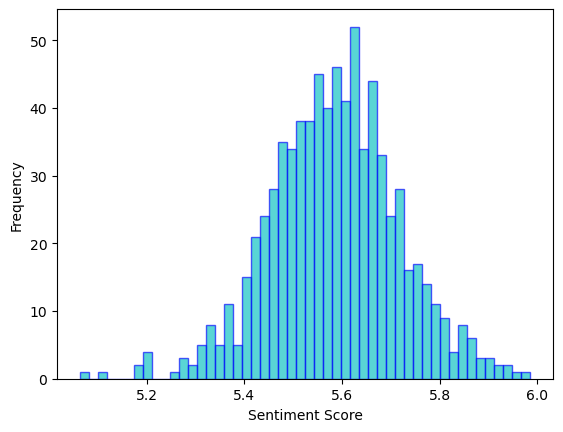

In [166]:
plt.hist(list(rappers_happiness.values()), bins=50, color='c', edgecolor='blue', alpha=0.65)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Find the 10 happiest and saddest wikipages

First we sort the rappers wikipages by sentiment score. Then we find the 10 lowest and highest scores.

In [167]:
sorted_rappers_happiness = dict(sorted(rappers_happiness.items(), key=lambda x:x[1], reverse=True))

In [168]:
print("Top 10 most happy rapper wikipages is: ")
for i in range(10):
    print(i+1, ")",list(sorted_rappers_happiness.keys())[i],"(", f'{list(sorted_rappers_happiness.values())[i]:.3f}', ")")

print("\n")
print("Top 10 least happy rapper wikipages is: ")
for i in range(10):
    print(i+1, ")",list(sorted_rappers_happiness.keys())[-i-1],"(", f'{list(sorted_rappers_happiness.values())[-i-1]:.3f}',")")

Top 10 most happy rapper wikipages is: 
1 ) Dave Free ( 5.986 )
2 ) Rashad Smith (producer) ( 5.960 )
3 ) Chanel West Coast ( 5.942 )
4 ) Queen Latifah ( 5.935 )
5 ) Cory Gunz ( 5.926 )
6 ) Awkwafina ( 5.922 )
7 ) Xzibit ( 5.909 )
8 ) DJ Skee ( 5.905 )
9 ) Redfoo ( 5.896 )
10 ) DJ Disco Wiz ( 5.885 )


Top 10 least happy rapper wikipages is: 
1 ) Cool C ( 5.062 )
2 ) 6ix9ine ( 5.103 )
3 ) Daz Dillinger ( 5.179 )
4 ) Hussein Fatal ( 5.190 )
5 ) YGD Tha Top Dogg ( 5.194 )
6 ) Fred the Godson ( 5.195 )
7 ) Rob Stone (rapper) ( 5.203 )
8 ) Chinx ( 5.206 )
9 ) Sheff G ( 5.255 )
10 ) Conceit (rapper) ( 5.270 )


### Compute sentiment of each coast

In [172]:
EastNames = [name for name in rappers[rappers['Coast'] == 'East']['WikipediaPageName'].tolist() if name in rappers_happiness.keys()]
WestNames = [name for name in rappers[rappers['Coast'] == 'West']['WikipediaPageName'].tolist() if name in rappers_happiness.keys()]

EastHappiness = [rappers_happiness[name] for name in EastNames]
WestHappiness = [rappers_happiness[name] for name in WestNames]

avg_east = np.mean(EastHappiness)
avg_west = np.mean(WestHappiness)

print("The mean sentiment score for east coast rappers is: ", f'{avg_east:.3f}')
print("The mean sentiment score for west coast rappers is: ", f'{avg_west:.3f}')

The mean sentiment score for east coast rappers is:  5.589
The mean sentiment score for west coast rappers is:  5.579


### Random shuffle test on the east coast.

Since the the east coast has the highest sentiment scores, we test if this is significantly higher than a random group of rappers of the same size. We do this by shuffling the labels of the rappers and then calculating the mean sentiment score. This is repeated 1000 times and we calculate the fraction of which the original east coast sentiment is higher than the random score.

In [173]:
coast = rappers['Coast'].tolist()
# random shuffle

count2 = 0
n = 1000
for i in range(n):
    np.random.shuffle(coast)
    rappers['Coast_r'] = coast
    
    EastNames_r = [name for name in rappers[rappers['Coast_r'] == 'East']['WikipediaPageName'].tolist() if name in rappers_happiness.keys()]
    EastHappiness_r = [rappers_happiness[name] for name in EastNames_r]

    avg_east_r = np.mean(EastHappiness_r)

    if avg_east > avg_east_r:
        count2 += 1

print("The percentage is: ", count2/n*100, "%")

The percentage is:  83.8 %


On a 5% confidence bound we can reject the null hypothesis that the east coast sentiment is not significantly higher than a random group of rappers of the same size. Hence we can conclude that the east coast sentiment is significantly higher than a random group of rappers of the same size.